In [ ]:
#export 
from local.torch_basics import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.all import *
from local.optimizer import *
from local.learner import *
from local.metrics import *
from local.callback.all import *
from local.vision.core import *
from local.vision.augment import *
from local.vision import models

In [ ]:
#default_exp vision.learner

In [ ]:
from local.notebook.showdoc import *

# Learner for the vision applications

> All the functions necessary to build `Learner` suitable for transfer learning in computer vision

## Cut a pretrained model

In [ ]:
# export
def _is_pool_type(l): return re.search(r'Pool[123]d$', l.__class__.__name__)

In [ ]:
m = nn.Sequential(nn.AdaptiveAvgPool2d(5), nn.Linear(2,3), nn.Conv2d(2,3,1), nn.MaxPool3d(5))
test_eq([bool(_is_pool_type(m_)) for m_ in m.children()], [True,False,False,True])

In [ ]:
# export
def has_pool_type(m):
    "Return `True` if `m` is a pooling layer or has one in its children"
    if _is_pool_type(m): return True
    for l in m.children():
        if has_pool_type(l): return True
    return False

In [ ]:
m = nn.Sequential(nn.AdaptiveAvgPool2d(5), nn.Linear(2,3), nn.Conv2d(2,3,1), nn.MaxPool3d(5))
assert has_pool_type(m)
test_eq([has_pool_type(m_) for m_ in m.children()], [True,False,False,True])

In [ ]:
#export
def create_body(arch, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained)
    #cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int):      return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else:                           raise NamedError("cut must be either integer or a function")

`cut` can either be an integer, in which case we cut the model at the coresponding layer, or a function, in which case, this funciton returns `cut(model)`. It defaults to `cnn_config(arch)['cut']` if `arch` is in `cnn_config`, otherwise to the first layer that contains some pooling.

In [ ]:
tst = lambda p : nn.Sequential(nn.Conv2d(4,5,3), nn.BatchNorm2d(5), nn.AvgPool2d(1), nn.Linear(3,4))
m = create_body(tst)
test_eq(len(m), 2)

m = create_body(tst, cut=3)
test_eq(len(m), 3)

m = create_body(tst, cut=noop)
test_eq(len(m), 4)

## Num features

In [ ]:
#export
def in_channels(m):
    "Return the shape of the first weight layer in `m`."
    for l in flatten_model(m):
        if hasattr(l, 'weight'): return l.weight.shape[1]
    raise Exception('No weight layer')

In [ ]:
test_eq(in_channels(nn.Sequential(nn.Conv2d(5,4,3), nn.Conv2d(4,3,3))), 5)
test_eq(in_channels(nn.Sequential(nn.AvgPool2d(4), nn.Conv2d(4,3,3))), 4)
test_fail(lambda : in_channels(nn.Sequential(nn.AvgPool2d(4))))

In [ ]:
#export
def num_features_model(m):
    "Return the number of output features for `m`."
    sz = 32
    ch_in = in_channels(m)
    while True:
        #Trying for a few sizes in case the model requires a big input size.
        try: 
            with hook_output(m) as hook: 
                _ = m.eval()(one_param(m).new(1, ch_in, sz, sz).requires_grad_(False).uniform_(-1.,1.))
                return hook.stored.shape[1]
        except Exception as e:
            sz *= 2
            if sz > 2048: raise

In [ ]:
m = nn.Sequential(nn.Conv2d(5,4,3), nn.Conv2d(4,3,3))
test_eq(num_features_model(m), 3)

## Head and model

In [ ]:
#export
def create_head(nf, nc, lin_ftrs=None, ps=0.5, concat_pool=True, bn_final=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and out `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += BnDropLin(ni, no, True, p, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

In [ ]:
tst = create_head(5, 10)
tst

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=5, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
#export
def create_cnn_model(arch, nc, cut, pretrained=True, lin_ftrs=None, ps=0.5, custom_head=None,
                     bn_final=False, concat_pool=True):
    "Create custom convnet architecture using `base_arch`"
    body = create_body(arch, pretrained, cut)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, nc, lin_ftrs, ps=ps, concat_pool=concat_pool, bn_final=bn_final)
    else: head = custom_head
    return nn.Sequential(body, head)

In [ ]:
tst = create_cnn_model(models.resnet18, 10, None)

In [ ]:
tst[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
from local.data.block import *

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
imagenet_stats = broadcast_vec(1, 4, *imagenet_stats)

In [ ]:
pets = DataBlock(ts=(PILImage, Category), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

dbunch = pets.databunch(untar_data(URLs.PETS)/"images", ds_tfms=RandomResizedCrop(300, min_scale=0.5), bs=64,
                        dl_tfms=[*aug_transforms(size=224), Normalize(*imagenet_stats)])

In [ ]:
get_c(dbunch)

37

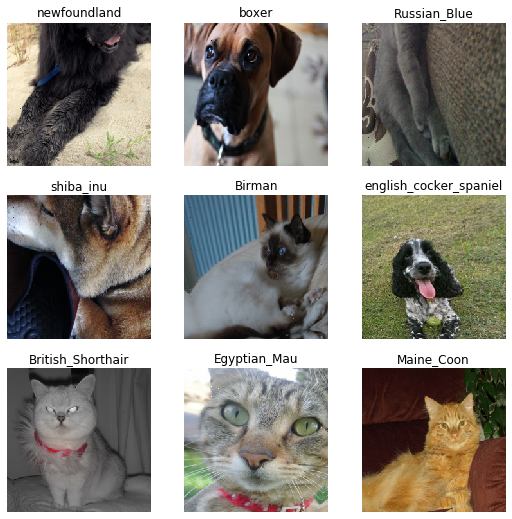

In [ ]:
dbunch.show_batch(max_n=9)

In [ ]:
#export
def _default_split(m:nn.Module): return L(m[0], m[1]).map(params)
def _resnet_split(m): return L(m[0][:6], m[0][6:], m[1]).map(params)
def _squeezenet_split(m:nn.Module): return L(m[0][0][:5], m[0][0][5:], m[1]).map(params)
def _densenet_split(m:nn.Module): return L(m[0][0][:7],m[0][0][7:], m[1]).map(params)
def _vgg_split(m:nn.Module): return L(m[0][0][:22], m[0][0][22:], m[1]).map(params)
def _alexnet_split(m:nn.Module): return L(m[0][0][:6], m[0][0][6:], m[1]).map(params)

_default_meta    = {'cut':None, 'split':_default_split}
_resnet_meta     = {'cut':-2, 'split':_resnet_split }
_squeezenet_meta = {'cut':-1, 'split': _squeezenet_split}
_densenet_meta   = {'cut':-1, 'split':_densenet_split}
_vgg_meta        = {'cut':-2, 'split':_vgg_split}
_alexnet_meta    = {'cut':-2, 'split':_alexnet_split}

In [ ]:
#export
model_meta = {
    models.resnet18 :{**_resnet_meta}, models.resnet34: {**_resnet_meta},
    models.resnet50 :{**_resnet_meta}, models.resnet101:{**_resnet_meta},
    models.resnet152:{**_resnet_meta},

    models.squeezenet1_0:{**_squeezenet_meta},
    models.squeezenet1_1:{**_squeezenet_meta},

    models.densenet121:{**_densenet_meta}, models.densenet169:{**_densenet_meta},
    models.densenet201:{**_densenet_meta}, models.densenet161:{**_densenet_meta},
    models.vgg11_bn:{**_vgg_meta}, models.vgg13_bn:{**_vgg_meta}, models.vgg16_bn:{**_vgg_meta}, models.vgg19_bn:{**_vgg_meta},
    models.alexnet:{**_alexnet_meta}}

In [ ]:
#export
@delegates(Learner.__init__)
def cnn_learner(dbunch, arch, cut=None, pretrained=True, lin_ftrs=None, ps=0.5, custom_head=None, splitter=trainable_params, bn_final=False, 
                init=nn.init.kaiming_normal_, concat_pool=True, **kwargs):
    "Build convnet style learner."
    meta = model_meta.get(arch)
    model = create_cnn_model(arch, get_c(dbunch), ifnone(cut, meta['cut']), pretrained, lin_ftrs, ps=ps, custom_head=custom_head,
        bn_final=bn_final, concat_pool=concat_pool)
    learn = Learner(dbunch, model, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    if init: apply_init(model[1], init)
    return learn

In [ ]:
learn = cnn_learner(dbunch, models.resnet34, loss_func=CrossEntropyLossFlat())

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_torch_core.ipynb.
Converted 02_script.ipynb.
Converted 03_dataloader.ipynb.
Converted 04_transform.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 22_vision_learner.ipynb.
Converted 23_tutorial_transfer_learning.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_text_models_core.ipynb.
Converted 34_callback_rnn.ipynb.